geinspireerd door : https://towardsdatascience.com/dating-algorithms-using-machine-learning-and-ai-814b68ecd75e 
data set verkregen door : https://generatedata.com/generator

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# pip install seaborn
# pip install sklearn 

In [3]:
df = pd.read_json("data-for_model.json")
df.head() 

,k1,k2,k3,k4,k5,S1,S2,D4
0,47,95,0,91,90,17,1,36
1,56,91,0,44,89,7,0,36
2,41,41,1,65,1,40,1,36
3,57,89,1,92,84,56,1,32
4,45,87,1,21,6,94,1,36


In [4]:
from sklearn.preprocessing import StandardScaler

# scaling the data 
scaler = StandardScaler().fit(df)
array_scaled = scaler.transform(df)

In [5]:
df_scaled = pd.DataFrame(array_scaled, columns = ['k1', 'k2', 'k3', 'k4', 'k5', 's1', 's2', 'd4'])
df_scaled

,k1,k2,k3,k4,k5,s1,s2,d4
0,-0.072216,1.620024,-1.033908,1.533957,1.464342,-1.181239,1.105542,0.583768
1,0.244831,1.478093,-1.033908,-0.183023,1.429811,-1.532102,-0.904534,0.583768
2,-0.283581,-0.296044,0.967204,0.584138,-1.608912,-0.374254,1.105542,0.583768
3,0.280058,1.407127,0.967204,1.570489,1.257156,0.187127,1.105542,-0.238440
4,-0.142671,1.336162,0.967204,-1.023247,-1.436257,1.520406,1.105542,0.583768
...,...,...,...,...,...,...,...,...
295,-0.671082,-0.437975,0.967204,1.460894,0.877316,1.134457,1.105542,-1.882856
296,0.456195,-1.360527,0.967204,-0.073428,0.152166,0.853767,-0.904534,0.583768
297,0.878924,-0.508941,-1.033908,-1.096310,0.014043,-1.672447,-0.904534,1.405976
298,0.491422,-1.289561,-1.033908,1.095579,0.462945,-0.409340,1.105542,1.405976


In [6]:
# bewijs dat het genormaliseerd : 
df_scaled.mean()

# afgerond is dit 0 

k1    1.065814e-16
k2    5.921189e-18
k3   -1.450691e-16
k4    7.105427e-17
k5   -2.368476e-17
s1    8.289665e-17
s2   -1.184238e-17
d4    7.016610e-16
dtype: float64

In [21]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# kiezen van het aantal clusters 

cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scoresA = []
db_scoresA = []

s_scoresB = []
db_scoresB = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_scaled)
    
    cluster_assignmentsA = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    k_means = KMeans(n_clusters=i)
    
    k_means.fit(df_scaled)
    
    cluster_assignmentsB = k_means.predict(df_scaled)
    
    # Appending the scores to the empty lists    
    s_scoresA.append(silhouette_score(df_scaled, cluster_assignmentsA))
    db_scoresA.append(davies_bouldin_score(df_scaled, cluster_assignmentsA))
    
    s_scoresB.append(silhouette_score(df_scaled, cluster_assignmentsB))
    db_scoresB.append(davies_bouldin_score(df_scaled, cluster_assignmentsB))

In [24]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
        
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('Het aantal clusters')
    plt.ylabel('Score')
    plt.show()
    


Grafiek 1  - "The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect. "

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam#:~:text=The%20silhouette%20score%20of%201,value%20of%20the%20K%20(no.


Grafiek 2 - "Davies-Bouldin index is a validation metric that is often used in order to evaluate the optimal number of clusters to use. It is defined as a ratio between the cluster scatter and the cluster's separation and a lower value will mean that the clustering is better " 

https://stackoverflow.com/questions/59279056/davies-bouldin-index-higher-or-lower-score-better#:~:text=Davies%2DBouldin%20index%20is%20a,that%20the%20clustering%20is%20better.


Max Value:
Cluster #     Cluster Score
19       0.129011

Min Value:
Cluster #    Cluster Score
5       0.077047


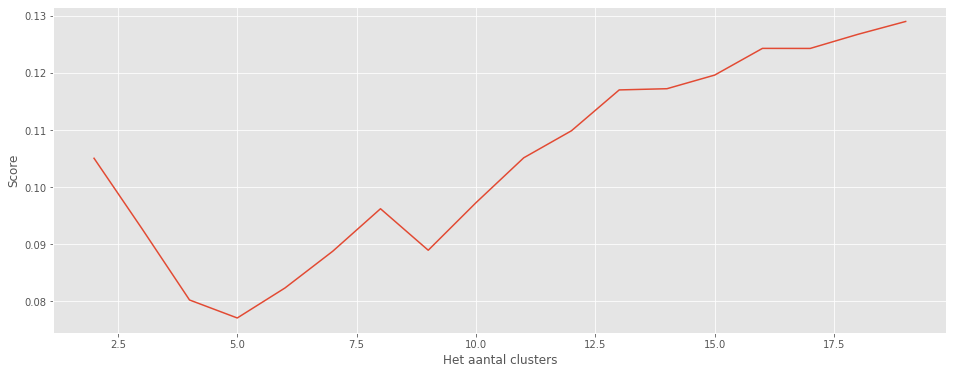

Max Value:
Cluster #    Cluster Score
2       2.790762

Min Value:
Cluster #     Cluster Score
19        1.61575


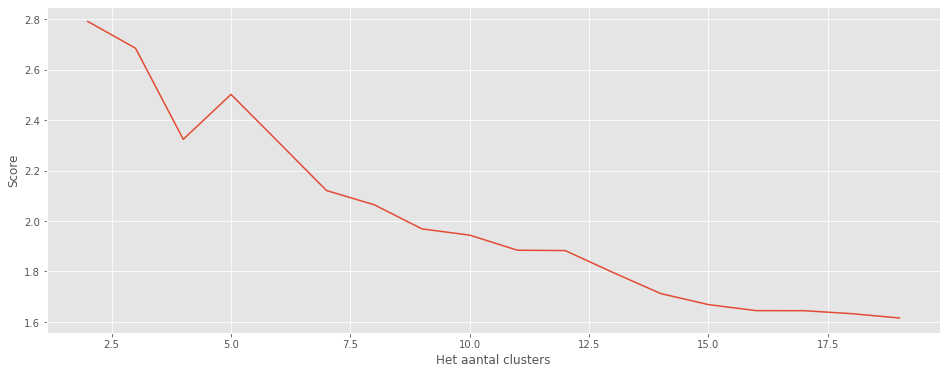

In [25]:
# Running the function on the list of scores
plot_evaluation(s_scoresA)
plot_evaluation(db_scoresA)

Dus vanuit deze twee grafieken is 16 het optimale aantal clusters. En gebruiken kmeans 

### AgglomerativeClustering

grafiek 1 de max is bij 19 clusters met een waarde van 0.129011

grafiek 2 de min is bij 19 clusters met een waarde van 1.61575

Max Value:
Cluster #     Cluster Score
17       0.140338

Min Value:
Cluster #    Cluster Score
3       0.110383


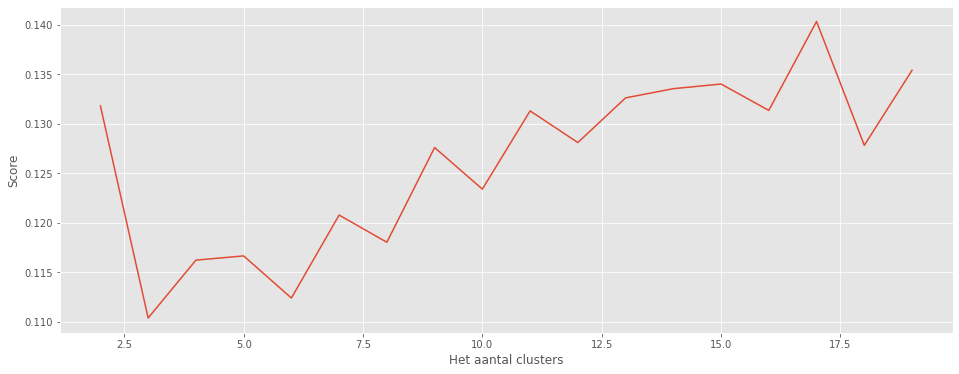

Max Value:
Cluster #    Cluster Score
2       2.521468

Min Value:
Cluster #     Cluster Score
19       1.595732


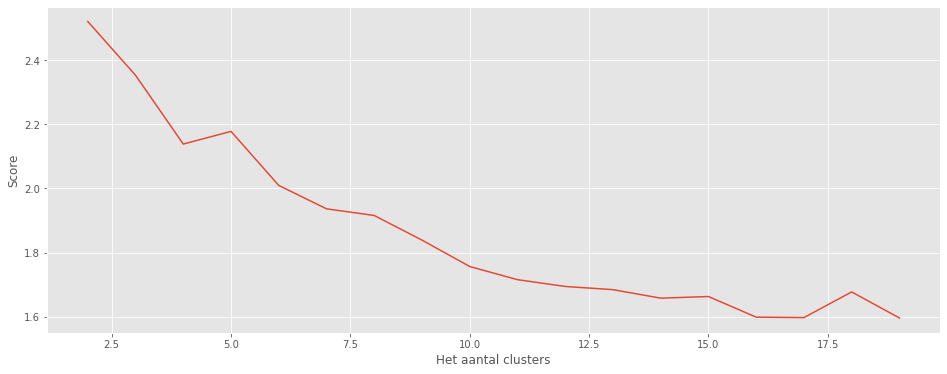

In [26]:
plot_evaluation(s_scoresB)
plot_evaluation(db_scoresB)

### Kmeans 
grafiek 1 de max is bij 17 clusters met een waarde van 0.140338

grafiek 2 de min is bij 19 clusters met een waarde van 1.595732

### Conclusie 
De waarden zijn nagenoeg gelijk voor beide clustering methodes. Maar AgglomerativeClustering heeft een kleine voor sprong. En heeft bij beide evaluatie methodes de piek/dal bij 19 zitten. 

In [32]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=19)

# Fitting
hac.fit(df_scaled)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
df_scaled['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df_scaled

,k1,k2,k3,k4,k5,s1,s2,d4,Cluster #
0,-0.072216,1.620024,-1.033908,1.533957,1.464342,-1.181239,1.105542,0.583768,11
1,0.244831,1.478093,-1.033908,-0.183023,1.429811,-1.532102,-0.904534,0.583768,15
2,-0.283581,-0.296044,0.967204,0.584138,-1.608912,-0.374254,1.105542,0.583768,18
3,0.280058,1.407127,0.967204,1.570489,1.257156,0.187127,1.105542,-0.238440,8
4,-0.142671,1.336162,0.967204,-1.023247,-1.436257,1.520406,1.105542,0.583768,17
...,...,...,...,...,...,...,...,...,...
295,-0.671082,-0.437975,0.967204,1.460894,0.877316,1.134457,1.105542,-1.882856,8
296,0.456195,-1.360527,0.967204,-0.073428,0.152166,0.853767,-0.904534,0.583768,1
297,0.878924,-0.508941,-1.033908,-1.096310,0.014043,-1.672447,-0.904534,1.405976,15
298,0.491422,-1.289561,-1.033908,1.095579,0.462945,-0.409340,1.105542,1.405976,6


C:\Users\Merel\AppData\Local\Temp/ipykernel_22404/1296007025.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter); plt.show()


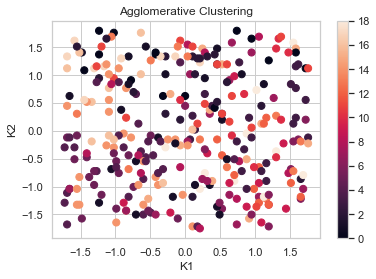

In [39]:
data = df_scaled
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data['k1'],[data['k2']], c=data["Cluster #"],s=50)
ax.set_title("Agglomerative Clustering")
ax.set_xlabel("K1"); ax.set_ylabel("K2")
plt.colorbar(scatter)
plt.show()

In [40]:
df